In [78]:
import json
import openai
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import csv
from AI_Responder_Settings import responder_settings

In [31]:
import importlib
import AI_Responder_Settings
importlib.reload(AI_Responder_Settings)

<module 'AI_Responder_Settings' from '/Users/justinkim/Documents/GitHub/crowdsourcing-te/AI_Responder_Settings.py'>

In [41]:
with open("openai_key.txt", "r") as f:
    api_key = f.read().strip()

openai_key = api_key

In [53]:
def call_ai_gpt(
        model_name, temp, instructions, input_prompt
        ):
    client = openai.OpenAI(api_key = openai_key)
    completion = client.chat.completions.create(
    model=model_name,
    messages=[
        {"role": "system", "content": instructions},
        {"role": "user", "content": input_prompt}
    ],
    temperature = temp,
    response_format = { "type": "json_object" }
    )

    return completion

In [34]:
simulate = """
Simulate the responses of 5 independent Amazon Mechanical Turk workers answering a given task. 
Assume each worker will attempt to provide some answer to the best of their ability despite a lack of experience or knowledge. """

formatting = """

Making sure NOT to include preceding string that says "json"; output ONLY a json in the following format:

{
    "responses": [
        {
            "confidence": 3,
            "reason": "...",
            "answer": "..."
        },
        {
            ...
        ...
    ]
}
"""

intro = """
Introduction: Many individuals with autism visit online communities
to ask questions about issues they are facing. We would like to know
whether people outside of the specific community could provide
answers for them. A question from a special autism community will
be shown to you. Please read the question carefully, rate your
confidence and provide your own answer to the question.
"""

tasks = """
Tasks:
1. Rate your confidence in being able to answer this question.
(1) Not confident at all - (2) Slightly confident -
(3) Somewhat confident - (4) Very confident -
(5) Extremely confident
2. Explain the reason for your confidence rating:
3. Please answer the question, or explain why you cannot answer:
"""


In [35]:
all_questions = []
with open('questions.csv', mode ='r') as file:    
       csvFile = csv.DictReader(file)
       for lines in csvFile:
              all_questions.append(lines)

In [36]:
ai_answers = {}
for setting in responder_settings[3:]:
    name = setting["setting_name"]
    ai_answers[name] = {}
    for question in all_questions[0:6]:
        scenario = f"""
        Question Title: {question["Title"]}
        Question Body: {question["Body"]}
    """

        instructions = simulate + setting["additional_information"] + setting["token_limit"] + formatting
        prompt =  intro + scenario + tasks 

        raw_out = call_ai_gpt(setting["model"], setting["temp"], instructions, prompt)
        resp = raw_out.choices[0].message.content
        response = json.loads(resp)["responses"]
        for answer in response:
            ai_answers[name].setdefault(question["Body"], []).append(answer["answer"])

with open('ai_answers.json', 'w') as f:
    json.dump(ai_answers, f, ensure_ascii=False, indent=4)
print(json.dumps(ai_answers, ensure_ascii=False, indent=4))  



{
    "Low token limit setting": {
        "Well, like the subject says, anyone have Skype and are they up to talking to other people?\n \n\n I know that it doesn't really seem like it would go hand-in-hand with Autism, but perhaps it might be another way for people with Autism to communicate with each other and just hang out and talk. And who knows, perhaps it might help in being sociable with other people.": [
            "Yes, Skype can be a helpful way for people with autism to connect and talk with others. It provides a safe environment to communicate without face-to-face pressure.",
            "I think some people with autism might use Skype to reach out or communicate more comfortably since it is less direct than in-person.",
            "Skype is definitely a good option for people with autism as it allows them to socialize from a comfortable distance and time frame.",
            "I’m not sure about specific Skype use in autism, but it might be useful for some to connect with

In [37]:
outgroup_answers = {}
with open('out-group_answers.csv', mode ='r') as file:    
       csvFile = csv.DictReader(file)
       for lines in csvFile:
              outgroup_answers.setdefault(lines["Input.body"], []).append(lines["Answer.answer"])

print(json.dumps(outgroup_answers, indent=4))  

{
    "Well, like the subject says, anyone have Skype and are they up to talking to other people?\n\nI know that it doesn't really seem like it would go hand-in-hand with Autism, but perhaps it might be another way for people with Autism to communicate with each other and just hang out and talk. And who knows, perhaps it might help in being sociable with other people.": [
        "Phone conversations can be difficult even for people not on the spectrum! But setting up some regular conversation times seems like a helpful and fun idea.",
        "skype is a good tool for interaction with those that are far away and distant. i personally used skype and i hated it. i preferred the sticking to texting the person. In your case, i think it would work great. I would start off by spreading the word on social media in groups on facebook that deal with autism. that would eliminate anyone who shouldnt be there and help the whole skype experience be better because you are a group of people who are 

In [50]:
with open('ai_answers.json', 'r') as file:
    ai_answers = json.load(file)



In [56]:
intro = """
You are simulating the role of a rater: you are given a question below and your task is to rate a response to the question according to several criteria. 
Making sure NOT to include any preceding string that says json, output ONLY a json of a dictionary with each criteria and its rating being a key-value pair according to the below format:

{
  "Helpfulness": 4,
  "Emotional support": "Yes",
  "Directness": "Yes",
  "Additional Information Provided": "No",
  "Justification": "..."
}
"""

tasks = """
Rate this response using the following criteria:
Helpfulness (1-5) scale: How effectively does the response address the question or provide useful advice?
Emotional support = Yes/No: Does the response convey empathy or offer emotional reassurance?
Directness (Yes/No) is the repsonse clear and straightforward?
Additional Information Provided (Yes/No): Does the response include any extra information that could be useful?
Also provide a justification for the above ratings.
"""
answers = ai_answers
questions_length = 5
responses_length = 5
divisor = questions_length * responses_length

setting_names = []
ratings = []
metrics = ["Helpfulness", "Emotional support", "Directness", "Additional info"]

for i, setting in enumerate(answers.keys()):
  select_questions = list(answers[setting].keys())[0:questions_length]
  helpfulness, emotional_support, directness, additional_info = 0, 0, 0, 0
  for j, question in enumerate(select_questions):
    for response in answers[setting][question]:
        prompt_question = "\nConsider the question: " + question
        prompt_response = "\nNow consider the following response: " + response
        prompt = prompt_question + prompt_response + tasks

        raw_out = call_ai_gpt("gpt-4.1-mini", 1, intro, prompt)
        response = json.loads(raw_out.choices[0].message.content)

        print(response)

        helpfulness += int(response["Helpfulness"])
        emotional_support = (emotional_support + 1) if response["Emotional support"] == "Yes" else emotional_support
        directness = (directness + 1) if response["Directness"] == "Yes" else directness
        additional_info = (additional_info + 1) if response["Additional Information Provided"] == "Yes" else additional_info

  helpfulness /= divisor
  emotional_support /= divisor
  directness /= divisor
  additional_info /= divisor

  curr_rating = [helpfulness, emotional_support, directness, additional_info]


  setting_names.append(setting)
  ratings.append(curr_rating)


{'Helpfulness': 4, 'Emotional support': 'Yes', 'Directness': 'Yes', 'Additional Information Provided': 'Yes', 'Justification': 'The response effectively addresses the question by affirming that Skype can be a helpful communication tool for people with autism and explaining why (less pressure than in-person meetings). It offers emotional support by acknowledging the potential benefits and encouraging socializing in a comfortable environment. The response is clear and straightforward, directly relating to the question. Additionally, it provides useful extra information about the nature of Skype communications and its suitability for socially anxious individuals.'}
{'Helpfulness': 4, 'Emotional support': 'Yes', 'Directness': 'Yes', 'Additional Information Provided': 'Yes', 'Justification': 'The response effectively addresses the question by suggesting that Skype could be a useful communication tool for people with autism, acknowledging the potential benefit of less overwhelming remote int

In [57]:
print(ratings)

[[3.56, 0.56, 1.0, 0.8], [3.48, 0.6, 1.0, 0.68], [3.56, 0.52, 1.0, 0.84], [3.16, 0.24, 1.0, 0.48], [3.4, 0.44, 1.0, 0.56], [3.64, 0.48, 1.0, 0.76], [3.8, 0.6, 1.0, 0.84], [3.8, 0.68, 1.0, 0.72], [3.88, 0.72, 1.0, 0.84], [3.84, 0.76, 1.0, 0.68]]


In [58]:
print(setting_names)

['Default setting', 'Low temperature setting', 'High temperature setting', 'Low token limit setting', 'No token limit setting', 'Model GPT-4.1-nano setting', 'No details setting', 'High details setting', 'Autism expertise assignment setting', 'Example answer setting']


In [60]:
metrics = ["Helpfulness", "Emotional support", "Directness", "Additional info"]


[[3.6, 0.6, 1.0, 0.8], [3.52, 0.72, 1.0, 0.68]]


In [72]:
converted_ratings = np.array(ratings)
converted_ratings[:, 0] = converted_ratings[:, 0] / 5
print(converted_ratings)


[[0.712 0.56  1.    0.8  ]
 [0.696 0.6   1.    0.68 ]
 [0.712 0.52  1.    0.84 ]
 [0.632 0.24  1.    0.48 ]
 [0.68  0.44  1.    0.56 ]
 [0.728 0.48  1.    0.76 ]
 [0.76  0.6   1.    0.84 ]
 [0.76  0.68  1.    0.72 ]
 [0.776 0.72  1.    0.84 ]
 [0.768 0.76  1.    0.68 ]]


/var/folders/fq/dnsk_50d2rs12fgpvqngm9zm0000gn/T/ipykernel_23786/3380680300.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')  # or any sequential colormap


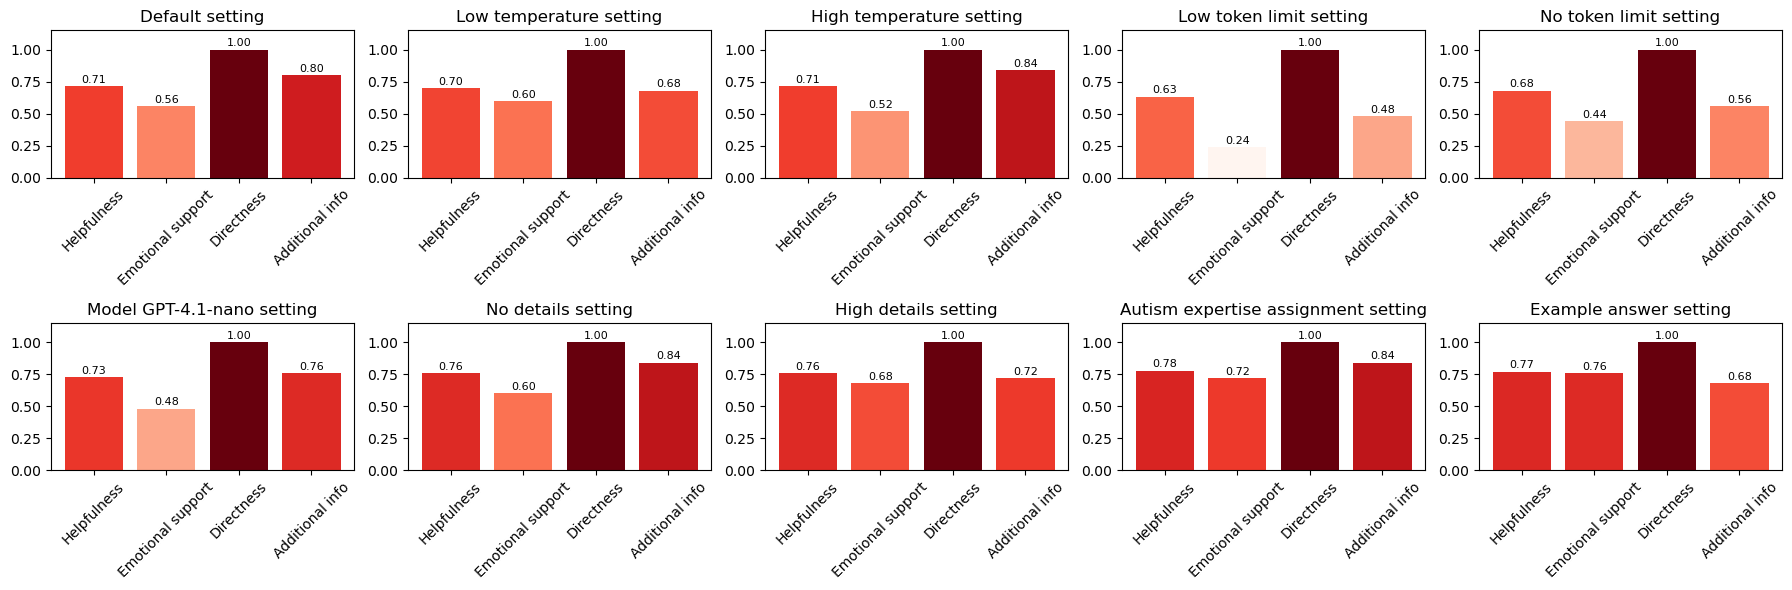

In [92]:
fig, axes = plt.subplots(2, 5, figsize=(18, 6))
axes = axes.flatten()  # flatten to 1D array to loop over easily

# Normalize across all data to keep color scale consistent
norm = mcolors.Normalize(vmin=np.min(converted_ratings), vmax=np.max(converted_ratings))
cmap = cm.get_cmap('Reds')  # or any sequential colormap


for i, ax in enumerate(axes):
    values = converted_ratings[i]
    colors = cmap(norm(values))  # Get color for each bar based on height

    bars = ax.bar(metrics, converted_ratings[i], color=colors)
    ax.set_title(setting_names[i])
    ax.set_ylim(0, 1.15)  # consistent scale across plots
    ax.tick_params(axis='x', rotation=45)

    # Add text labels above each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,  # small padding above the bar
            f'{height:.2f}',  # format number
            ha='center', va='bottom', fontsize=8
        )

plt.tight_layout()
plt.show()


    


In [ ]:
print(colors)